TC Energy Case Study. Completed by Michelle Li.

# Data Preprocessing

In [1]:
# Import the libraries
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import time
import seaborn as sns
from math import sqrt
import pickle
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.pyplot import figure
%matplotlib inline

import sklearn
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lars, Lasso, TheilSenRegressor, HuberRegressor
from sklearn.linear_model import OrthogonalMatchingPursuit, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the data file, and read the first 5 records of the dataset
house = pd.read_csv('housing.csv')
house.head()

,elevation,dist_am1,dist_am2,dist_am3,bath,sqft,parking,precip,price
0,35,9796,5250,10703,3,1961,Open,530,554083
1,26,8294,8186,12694,2,1752,Not Provided,210,331833
2,35,11001,14399,16991,2,1609,Not Provided,720,450083
3,23,8301,11188,12289,2,1748,Covered,620,447750
4,38,10510,12629,13921,2,2111,Not Provided,450,388500


In [3]:
# Check the data types of the dataset
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   elevation  500 non-null    int64 
 1   dist_am1   500 non-null    int64 
 2   dist_am2   500 non-null    int64 
 3   dist_am3   500 non-null    int64 
 4   bath       500 non-null    int64 
 5   sqft       500 non-null    int64 
 6   parking    500 non-null    object
 7   precip     500 non-null    int64 
 8   price      500 non-null    int64 
dtypes: int64(8), object(1)
memory usage: 35.3+ KB


>The dataset contains 9 variables and 500 observations, which include:
>- 1 target variable 'price' 
>- 1 categorical feature ('parking')  
>- 7 numerical features

In [4]:
# Check for duplicated rows of the dataset
house.duplicated().sum()

0

>The dataset does not contain any duplicated rows.

In [5]:
# Check for missing values
house.isnull().sum()

elevation    0
dist_am1     0
dist_am2     0
dist_am3     0
bath         0
sqft         0
parking      0
precip       0
price        0
dtype: int64

>The dataset does not contain any missing values.

In [6]:
# Create a statistics report of the numerical variables
round(house.describe(), 2)

,elevation,dist_am1,dist_am2,dist_am3,bath,sqft,precip,price
count,500.00,500.00,500.00,500.00,500.00,500.00,500.00,500.00
mean,30.27,8258.49,11036.59,13092.76,2.56,1816.10,793.16,510508.84
std,5.20,2590.40,2592.22,2629.43,2.81,572.13,272.49,555697.86
min,9.00,604.00,4402.00,4922.00,1.00,932.00,-110.00,124333.00
25%,27.00,6439.75,9229.25,11215.75,2.00,1588.50,610.00,380271.00
50%,30.00,8219.00,11015.00,13188.00,2.00,1770.50,790.00,481042.00
75%,34.00,10011.25,12848.50,14775.75,3.00,2003.00,980.00,593750.25
max,47.00,20662.00,20945.00,23294.00,63.00,12730.00,1530.00,12500000.00


>The statistics summary provides an overview of the numerical variables. Some variables may contain outliers, which should be further investigated. For example, the table shows the minimum value of 'precip' is less than zero.

# Exploratory Data Analysis and Feature Engineering

### Detect and Handle Outliers

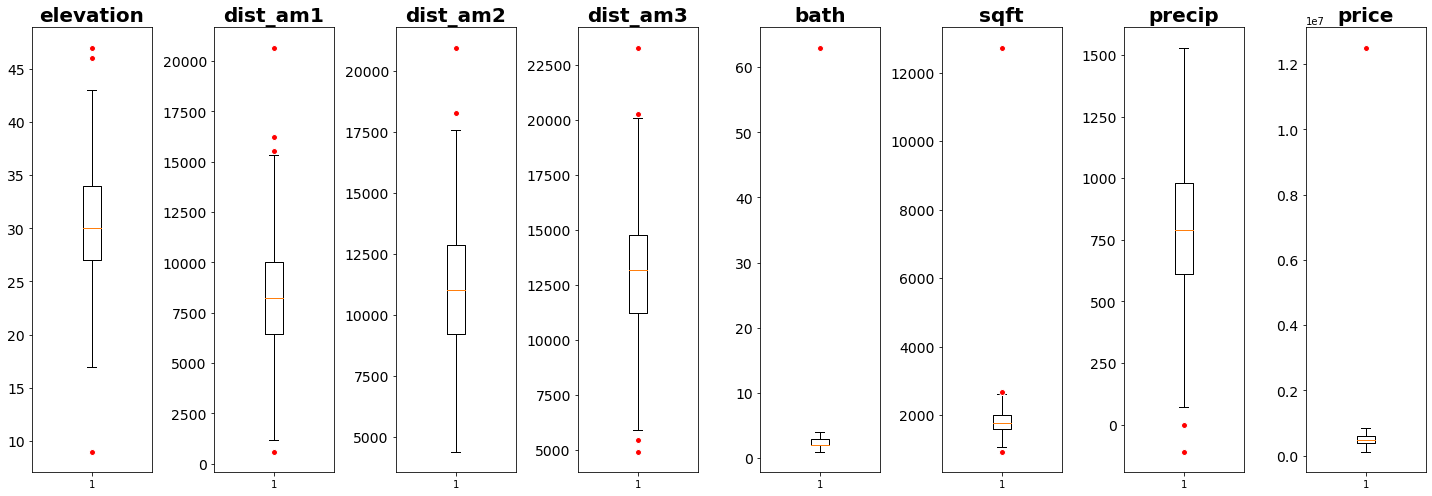

In [7]:
# Creating sub-boxplots for the numerical features with their own scales
house_new = house.drop(['parking'], axis = 1)
red_circle = dict(markerfacecolor = 'red', marker='o', markeredgecolor = 'white')
fig, axs = plt.subplots(1, len(house_new.columns), figsize = (20, 7))
for i, ax in enumerate(axs.flat):
    ax.boxplot(house_new.iloc[:, i], flierprops = red_circle)
    ax.set_title(house_new.columns[i], fontsize = 20, fontweight = 'bold')
    ax.tick_params(axis = 'y', labelsize = 14)
plt.tight_layout()

>- The boxplots display the distribution of the numerical features.
>- The red dots are potential outliers, which could largely skew the data distributions. Those outliers should be handled before building any machine learning models.

In [8]:
# Check for the skewness of the dataset before handling outliers
round(house_new.skew(axis = 0, skipna = True), 2)

elevation    -0.10
dist_am1      0.27
dist_am2      0.10
dist_am3      0.03
bath         20.01
sqft         13.94
precip       -0.01
price        20.20
dtype: float64

>The higher the score, the higher the skewness of the data distribution. With a high skewness score, the accuracy of a model prediction can become an unreliable measure of model performances.

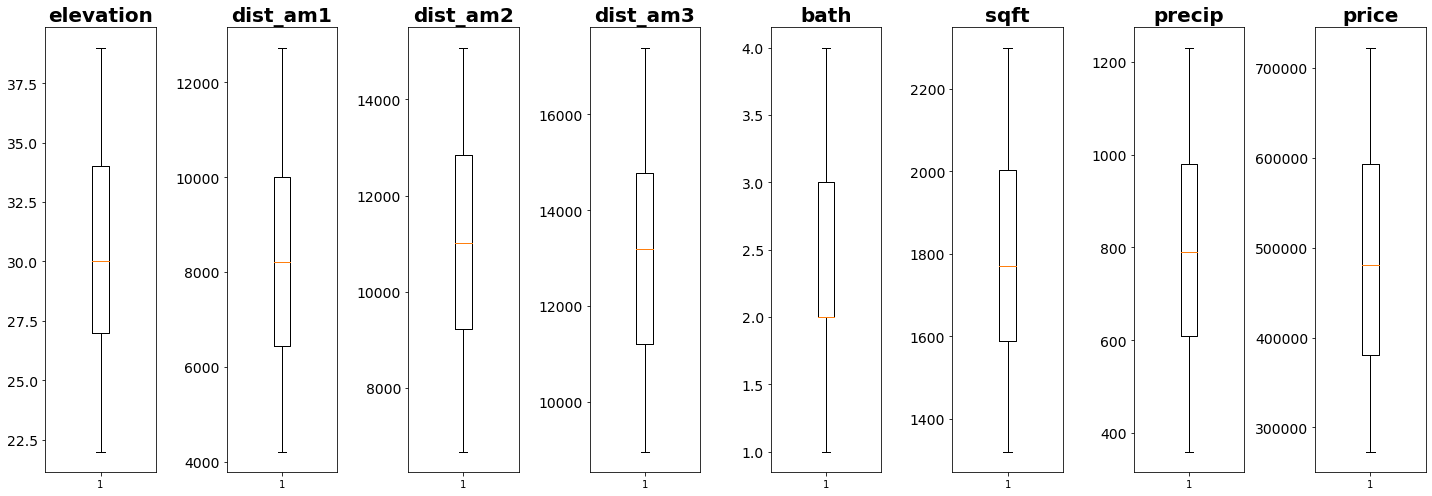

In [9]:
# Apply quantile filters to eliminate the outliers with upper quantile bound of 0.95 and the lower quantile bound of 0.05
house_clipped = house_new.apply(lambda col: col.clip(*col.quantile([0.05, 0.95]).values))

# Draw the sub-boxplots after handling the outlier 
red_circle = dict(markerfacecolor = 'red', marker = 'o', markeredgecolor = 'white')
fig, axs = plt.subplots(1, len(house_clipped.columns), figsize = (20, 7))
for i, ax in enumerate(axs.flat):
    ax.boxplot(house_clipped.iloc[:, i], flierprops = red_circle)
    ax.set_title(house_clipped.columns[i], fontsize = 20, fontweight = 'bold')
    ax.tick_params(axis = 'y', labelsize = 14)
plt.tight_layout()

>- Outliers are removed.
>- The distributions of the dataset are improved after reducing the outliers.

In [10]:
# Check for the skewness of the dataset after handling the outliers
round(house_clipped.skew(axis = 0, skipna = True), 2)

elevation    0.01
dist_am1     0.12
dist_am2    -0.08
dist_am3     0.02
bath         0.04
sqft         0.12
precip       0.02
price        0.10
dtype: float64

>The skewness is reduced after the outlier reductions. 

##### Histograms and Bar Charts

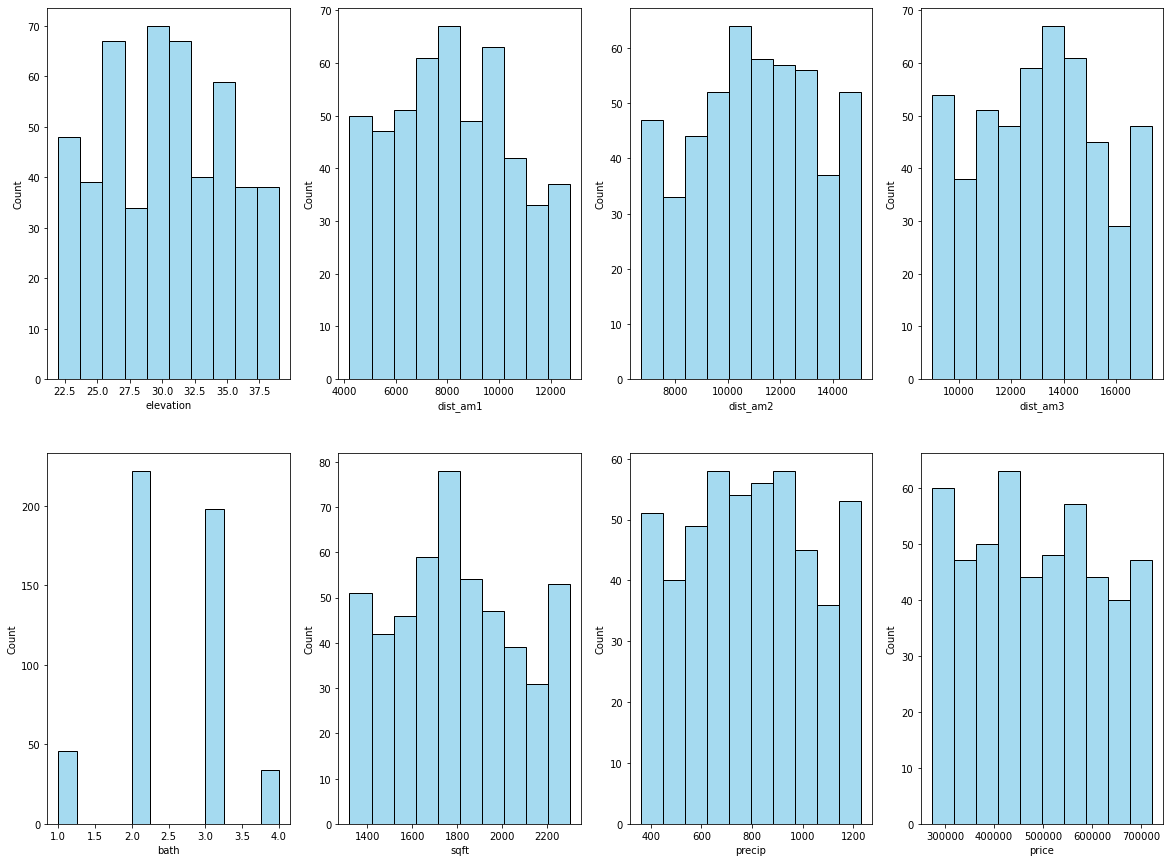

In [11]:
# Creating histograms for the numerical features 
f, axes = plt.subplots(2, 4, figsize = (20, 15))
for ax, feature in zip(axes.flat, house_clipped.columns):
    sns.histplot(house_clipped[feature] , color = 'skyblue', ax = ax)

>The histograms show the frequency distributions of the dataset.

In [12]:
#  Merge the numerical data back with the categorical data
data_ct = pd.concat([house_clipped, house.parking], axis = 1)

# Group the 'parking' types and calculate the total count for each one of them
data_ct['parking'].value_counts()

Open            196
Not Provided    126
Covered         105
No Parking       73
Name: parking, dtype: int64

In [13]:
# As 'No Parking' and 'Not Provided' types both create inconvenience for parking,
# merge these two types into one  
data_ct['parking'] = data_ct['parking'].replace('No Parking', 'Not Provided')
# Create a summary table of the 'parking' feature, to show the list of total observation numbers and their percentages 
unique, counts = np.unique(data_ct['parking'], return_counts = True)
result_pk = np.column_stack((unique, counts)) 
data_pk = pd.DataFrame(result_pk, columns = ['Parking Types', 'Counts'])
data_pk['Percentage'] = 100 * data_pk['Counts']  / (data_pk['Counts'].sum())
data_pk = data_pk.sort_values(by = ['Percentage'], ascending = False, ignore_index = True)
data_pk

,Parking Types,Counts,Percentage
0,Not Provided,199,39.8
1,Open,196,39.2
2,Covered,105,21.0


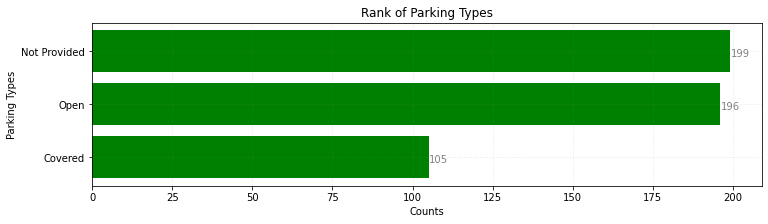

In [14]:
# Draw a bar chart for the 'parking' types
parking = data_pk['Parking Types']
count = data_pk['Counts']
fig, ax = plt.subplots(figsize = (12, 3))
ax.barh(parking, count, color = 'green')
ax.grid(b = True, color = 'grey', linestyle = '-.', linewidth = 0.5, alpha = 0.2)
ax.invert_yaxis()
for i in ax.patches:
    plt.text(i.get_width() + 0.2, i.get_y() + 0.5, str(round((i.get_width()), 2)), fontsize = 10, color = 'grey')
ax.set_title('Rank of Parking Types')
ax.set_ylabel('Parking Types')
ax.set_xlabel('Counts')
plt.show()

In [15]:
# Create a summary table for 'bath'
unique, counts = np.unique(data_ct['bath'], return_counts = True)
result_bt = np.column_stack((unique, counts)) 
data_bt = pd.DataFrame(result_bt, columns = ['# of Bathrooms', 'Counts'])
data_bt['Percentage'] = 100 * data_bt['Counts']  / (data_bt['Counts'].sum())
data_bt = data_bt.sort_values(by=['Percentage'], ascending = False, ignore_index = True)
data_bt

,# of Bathrooms,Counts,Percentage
0,2,222,44.4
1,3,198,39.6
2,1,46,9.2
3,4,34,6.8


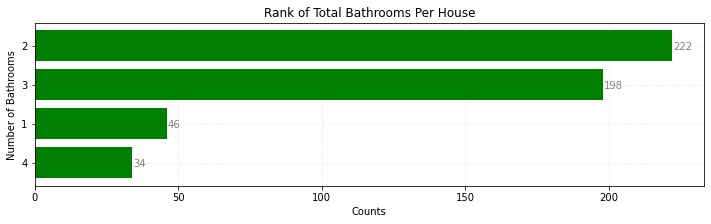

In [16]:
# Draw a bar chart for 'bath'
bath = data_bt['# of Bathrooms'].astype(str)
count = data_bt['Counts']
fig, ax = plt.subplots(figsize = (12, 3))
ax.barh(bath, count, color = 'green')
ax.grid(b = True, color = 'grey', linestyle = '-.', linewidth = 0.5, alpha = 0.2)
ax.invert_yaxis()
for i in ax.patches:
    plt.text(i.get_width() + 0.2, i.get_y() + 0.5, str(round((i.get_width()), 2)), fontsize = 10, color = 'grey')
ax.set_title('Rank of Total Bathrooms Per House')
ax.set_ylabel('Number of Bathrooms')
ax.set_xlabel('Counts')
plt.show()

##### Feature Correlation Analysis

In [17]:
# Convert the categorical feature into numerical features
data = pd.get_dummies(data_ct, columns = ['parking'])
data.head()

,elevation,dist_am1,dist_am2,dist_am3,bath,sqft,precip,price,parking_Covered,parking_Not Provided,parking_Open
0,35,9796.0,6676.75,10703.0,3,1961.0,530.0,554083.0,0,0,1
1,26,8294.0,8186.00,12694.0,2,1752.0,360.0,331833.0,0,1,0
2,35,11001.0,14399.00,16991.0,2,1609.0,720.0,450083.0,0,1,0
3,23,8301.0,11188.00,12289.0,2,1748.0,620.0,447750.0,1,0,0
4,38,10510.0,12629.00,13921.0,2,2111.0,450.0,388500.0,0,1,0


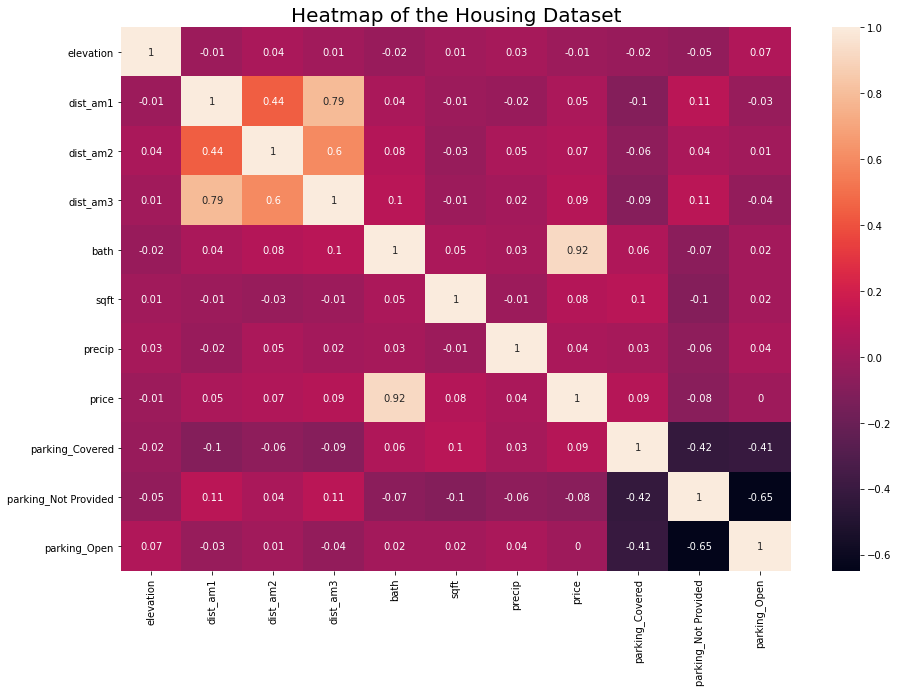

In [18]:
# Draw a heatmap to show a glance on how the variables are correlated with each other 
import seaborn as sns
import matplotlib.pyplot as plt
correlation_matrix = data.corr().round(2)
plt.figure(figsize = (15, 10))  
sns.heatmap(data = correlation_matrix, annot = True)
plt.title('Heatmap of the Housing Dataset', fontsize = 20)
plt.show()

>- The 'bath' feature has the highest positive correlation with 'price'
>- The 'elevation' and 'parking_No Provided' features have negative correlations with 'price'
>- The 'dist_am1', 'dist_am2', and 'dist_am3' features are highly correlated, which may cause potential multicollinearity problems. As these three features affect the house price independently, no feature reduction is needed.

In [19]:
# Extract the correlation score from the heatmap,
# The correlation score is how each feature related the 'price', in descending order
correlation_matrix2 = data.corr().round(2)
correlation_matrix2 = correlation_matrix2.sort_values(by = ['price'], ascending = False)
correlation_matrix2[['price']].round(2)

,price
price,1.00
bath,0.92
dist_am3,0.09
parking_Covered,0.09
sqft,0.08
dist_am2,0.07
dist_am1,0.05
precip,0.04
parking_Open,0.00
elevation,-0.01


>- The 'bath' feature has more than 10 times the impact on the Final House Sale Price than all other features (ex. square footage of the house) combined.
>- The 'elevation' and 'parking_No Provided' features have negative correlations with 'price'

Text(0, 0.5, 'House Price')

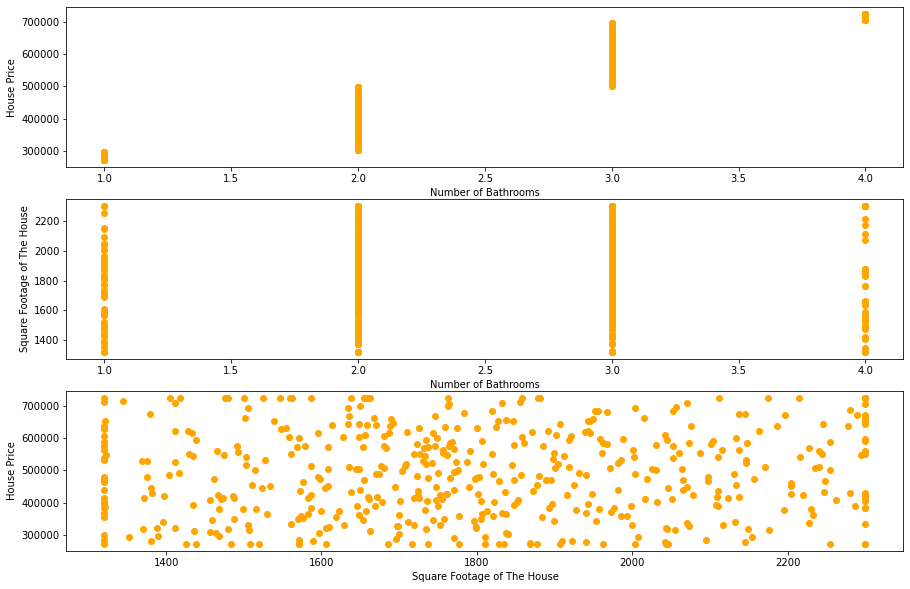

In [20]:
# Zoom in the correlations between several features with scatter plots
fig, ax = plt.subplots(3, figsize = (15, 10))
ax[0].scatter(x = data['bath'], y = data['price'], color = 'orange')
ax[0].set_xlabel('Number of Bathrooms')
ax[0].set_ylabel('House Price')

ax[1].scatter(x = data['bath'], y = data['sqft'], color = 'orange')
ax[1].set_xlabel('Number of Bathrooms')
ax[1].set_ylabel('Square Footage of The House')

ax[2].scatter(x = data['sqft'], y = data['price'], color = 'orange')
ax[2].set_xlabel('Square Footage of The House')
ax[2].set_ylabel('House Price')

>1. The 'bath' feature shows a positive correlation with 'price'.
>2. The number of bathrooms doesn't show a clear correlation with the square footage of the house.
>3. Square footage of the house doesn't have a clear correlation with the house price
>- To better predict the house price, more relevant features, such as the actual living square footage or number of rooms, should be included for further study.

In [21]:
# Check for multicollinearity score with VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
x_variables = data[['dist_am1', 'dist_am2', 'dist_am3']]
vif_data = pd.DataFrame()
vif_data['Feature'] = x_variables.columns
vif_data['VIF'] = [round(variance_inflation_factor(x_variables.values, i), 2) for i in range(len(x_variables.columns))]
vif_data

,Feature,VIF
0,dist_am1,33.87
1,dist_am2,33.01
2,dist_am3,74.45


>- Variance Inflation Factor (VIF) is a measure of the amount of multicollinearity in a set of multiple regression variables.
>- The VIF scores show 'dist_am1', 'dist_am2', and 'dist_am3' are highly correlated. However, these features affect the house price independently, so no feature reduction is needed.

# Machine Learning Model Building and Selection

Overall, 15 regression models were built to predict the house price. Regression is a supervised machine learning technique which is used to predict continuous values. The dataset was splitted into training (80%) and testing (20%) sets. In order to select a winning model, the model runtime was monitored and four evaluation metrics were applied:
- Coefficient of determination (R2): It is a measurement used in statistical analysis to assess how well a model explains and predicts future outcomes.
- Root Mean Squared Error (RMSE): It is the square root of the mean of the square of all of the errors. It measures the error of a model in predicting quantitative data.
- Mean Absolute Percentage Error (MAPE): It measures the prediction accuracy. It is the average of the absolute percentage errors of forecasts. Error is defined as actual or observed value minus the forecasted value.
- Root Mean Squared Error of Cross-Validation (RMSE_CV): Cross-validation estimates the skill of a machine learning model on unseen data. This metric measures the average RMSE for the dataset.

##### Baseline Model
Create a model to establish the baseline performance for the predictive modeling task.
The baseline provides a point of comparison for different modeling techniques.

In [22]:
# Rescale the features, except the target variable
data_prep = data.drop(['price'], axis = 1)
data_columns = data_prep.columns
scaler = MinMaxScaler()
data_scld = scaler.fit_transform(data_prep)

# Convert the rescaled numpy array into a dataframe
df = pd.DataFrame(data_scld)
df.columns = data_columns

# Extract the x, y values for the model building
x, y = df.iloc[:, :].values, data.price.values

# Split the data into training and testing sets: 80% for training and 20% for testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 100)

# Build the Linear Regression model
# Generate predictions from x_test and calculate the evaluation matrices
start_time_lr = time.time()
regressor_lr = LinearRegression()
model_lr = regressor_lr.fit(x_train, y_train)
y_pred_lr = model_lr.predict(x_test)

# Create the Mean Absolute Percentage Error (MAPE) function
def MAPE(y_actual, y_Predicted):
    mape = np.mean((np.abs(y_actual - y_Predicted) / y_actual)) * 100
    return mape

# Evaluate Model Performance
scores_lr = cross_val_score(model_lr, 
                         x_train, 
                         y_train,
                         scoring = 'neg_mean_squared_error', 
                         cv = 3)
print('Coefficient of determination (R2):', round(r2_score(y_test, y_pred_lr), 2))
print('Root Mean Squared Error: ', round(np.sqrt(mean_squared_error(y_test, y_pred_lr))))
print('Mean Absolute Percentage Error: ', round(MAPE(y_test, y_pred_lr), 2), '%')
print('Root Mean Squared Error of Cross-Validation: ', round(np.mean(np.sqrt(-scores_lr))))
print('Model Run Time: ',  round((time.time() - start_time_lr) / 60, 4))

Coefficient of determination (R2): 0.85
Root Mean Squared Error:  49333
Mean Absolute Percentage Error:  9.82 %
Root Mean Squared Error of Cross-Validation:  54368
Model Run Time:  0.0001


##### Candidate Model Comparison
A group of 12 candidate models are created to evaluate and select a winning model.

In [23]:
# Create a dictionary containing the name of each tested model, and the name of the model class
regressors = {
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'LarS': Lars(),
    'KernelRidge': KernelRidge(),
    'ElasticNet': ElasticNet(),
    'TheilSenRegressor': TheilSenRegressor(),
    'HuberRegressor': HuberRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'XGBRegressor': XGBRegressor(),
    'OrthogonalMatchingPursuit': OrthogonalMatchingPursuit(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
}

# Create a Pandas dataframe for storing the testing results
df_models = pd.DataFrame(columns = ['Model', 'Run_Time', 'R2', 'RMSE','RMSE_CV', 'MAPE (%)' ])

# Loop over each of the models, fit it using the x_train and y_train data,
# Generate predictions from x_test, create a model runtime monitor, and calculate the evaluation matrices
for key in regressors:

    print('*', key)
    
    start_time = time.time()
    
    regressor = regressors[key]
    model_candidate = regressor.fit(x_train, y_train)
    y_pred = model_candidate.predict(x_test)

    scores = cross_val_score(model_candidate, 
                             x_train, 
                             y_train,
                             scoring = 'neg_mean_squared_error', 
                             cv = 3)

    row = {'R2': round(r2_score(y_test, y_pred), 2),
           'Model': key,
           'Run_Time': format(round((time.time() - start_time) / 60, 4)),
           'RMSE': round(np.sqrt(mean_squared_error(y_test, y_pred))),
           'RMSE_CV': round(np.mean(np.sqrt(-scores))),
           'MAPE (%)': round(MAPE(y_test, y_pred), 2),
    }

    df_models = df_models.append(row, ignore_index = True)
    
# Create a sorted performance summary of each model
df_models.sort_values(by = 'MAPE (%)', ascending = True)

* Lasso
* Ridge
* LarS
* KernelRidge
* ElasticNet
* TheilSenRegressor
* HuberRegressor
* GradientBoostingRegressor
* XGBRegressor
* OrthogonalMatchingPursuit
* KNeighborsRegressor
* RandomForestRegressor


,Model,Run_Time,R2,RMSE,RMSE_CV,MAPE (%)
11,RandomForestRegressor,0.0101,0.85,49586,56495,9.05
1,Ridge,0.0001,0.86,48742,54554,9.33
7,GradientBoostingRegressor,0.0036,0.85,50669,57153,9.39
9,OrthogonalMatchingPursuit,0.0001,0.86,48642,53172,9.74
5,TheilSenRegressor,0.0298,0.86,48734,54939,9.77
0,Lasso,0.0001,0.85,49330,54365,9.82
2,LarS,0.0001,0.85,49333,54368,9.82
3,KernelRidge,0.0003,0.85,49915,54911,9.83
6,HuberRegressor,0.0006,0.84,51804,63073,9.91
8,XGBRegressor,0.0083,0.82,53925,61552,9.91


>- The testing results show the Random Forest Regressor model has the lowest prediction error (measured by MAPE). Also, Gradient Boosting Regressor and Ridge are on top of the rank.
>- The Random Forest Regressor model has a lower prediction error than the baseline model.
>- **Random Forest Regressor is the winning model so far.**

##### Ensemble Model - Stacking High Performing Candidate Models
Apply the stacking technique to ensemble three high performing models based on the testing results. This modeling technique aims to harness the strength of each model, thus increasing the prediction accuracy.

In [24]:
from mlxtend.regressor import StackingCVRegressor
# Initialize individual models
reg1 = GradientBoostingRegressor()
reg2 = RandomForestRegressor()
# Create meta-model
meta_model = Ridge()

# Create stacking classifier and train the model, create a model runtime monitor 
reg_stack = StackingCVRegressor(
regressors = [reg1, reg2], meta_regressor = meta_model,
use_features_in_secondary = False)
start_time_stk = time.time()
reg_stack.fit(x_train, y_train)

# Generate predictions from x_test
y_pred_stk = reg_stack.predict(x_test)

# Evaluate the model Performance
scores_stk = cross_val_score(reg_stack, 
                         x_train, 
                         y_train,
                         scoring = 'neg_mean_squared_error', 
                         cv = 3)
print('Coefficient of determination (R2):', round(r2_score(y_test, y_pred_stk), 2))
print('Root Mean Squared Error:', round(sqrt(mean_squared_error(y_test, y_pred_stk))))
print('Mean Absolute Percentage Error: ', round(MAPE(y_test, y_pred_stk), 2), '%')
print('Root Mean Squared Error of Cross-Validation:', round(np.mean(np.sqrt(-scores_stk))))

Coefficient of determination (R2): 0.86
Root Mean Squared Error: 48834
Mean Absolute Percentage Error:  8.95 %
Root Mean Squared Error of Cross-Validation: 55614


>- The ensemble model has a higher prediction error than the Random Forest Regressor
>- **Random Forest Regressor is the winning model so far.**

##### Hyperparameter Tuning the Top Performing Model (Random Forest Regressor)
Machine learning models come with default hyperparameters. Hyperparameters are the settings of an algorithm that can be adjusted to optimize performance. Their optimal values may vary from one data set to another. The tuning technique applied here is Random Search with Cross Validation. It uses the Scikit-Learn’s RandomizedSearchCV method. The search takes a manually defined grid of hyperparameter ranges as input, randomly samples from the grid, and performs K-Fold CV with each combination of values.

**Note:** The processes of hyperparameter tuning, and cross-validating the model accuracy are time consuming. Thus, I commented out the RMSE_CV evaluation code to reduce the run-time. The reduced run-time is around two to three minutes. 

In [25]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
grid = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
model_grid = RandomizedSearchCV(estimator = grid, param_distributions = random_grid, 
                                n_iter = 100, cv = 3, verbose = 2, random_state = 42, n_jobs = -1)
 
# Fit the random search model
model_grid.fit(x_train, y_train)

y_pred_grid = model_grid.predict(x_test)

# # Evaluate the model Performance
# scores_grid = cross_val_score(model_grid, 
#                          x_train, 
#                          y_train,
#                          scoring = 'neg_mean_squared_error', 
#                          cv = 3)
# print('Root Mean Squared Error of Cross-Validation: ', round(np.mean(np.sqrt(-scores_grid))))
print('Coefficient of determination (R2):', round(r2_score(y_test, y_pred_grid), 2))
print('Root Mean Squared Error: ', round(np.sqrt(mean_squared_error(y_test, y_pred_grid))))
print('Mean Absolute Percentage Error: ', round(MAPE(y_test, y_pred_grid), 2), '%')


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Coefficient of determination (R2): 0.86
Root Mean Squared Error:  49070
Mean Absolute Percentage Error:  8.89 %


>- The Random Forest Regressor with Hyperparameter Tuning has a higher prediction error than the Random Forest Regressor
>- **Random Forest Regressor is the final winning model.**

##### Select A Winning Model

- Based on the above model testing, the winning model is the **Random Forest Regressor**. It achieves the highest prediction accuracy with the lowest error range (MAPE: 8.80%; RMSE: 48317). Its R2 and RMSE_CV results are also relatively decent compared to other models. However, as the R2 and RMSE_CV are influenced by the data quality and size, thus they are not considered as the primary winning model selection criterias. Its model run-time is slightly higher than some models; but it's still within an acceptable range.

- With a limited set of data points, a sophisticated model like the ensemble model does not necessarily provide a better prediction accuracy. The sophisticated model might be overfitted with the small size training dataset. Once the model is tested on unseen dataset, which may or may not follow the exact pattern as the training dataset, its prediction performance could be decreased.


>- **Note:** Due to the limited training data size, the model testing results may vary from run to another, thus I saved a copy of the winning model (Random Forest Regressor) for consistency.

In [26]:
# # Generate and save the selected model (as I already saved the winning model, I commented out this section).
# # The to be saved model name is adjusted slightly here, so it won't overwrite the previously saved one.
# regressor_rf = RandomForestRegressor()
# model_rf = regressor_rf.fit(x_train, y_train)

# with open('bestmodel_rf', 'wb') as files:
#     pickle.dump(model_rf, files)

In [27]:
# Load the saved winning model: the Random Forest Regressor model
with open('best_model' , 'rb') as f:
    best_model = pickle.load(f)

# Generate predictions from x_test
y_pred_rf = best_model.predict(x_test)

# Re-generate the evaluations on the winning model (Random Forest Regressor) performances
scores_rf = cross_val_score(best_model, 
                         x_train, 
                         y_train,
                         scoring = 'neg_mean_squared_error', 
                         cv = 3)                
print('Coefficient of determination (R2):', round(r2_score(y_test, y_pred_rf), 2))
print('Root Mean Squared Error:', round(sqrt(mean_squared_error(y_test, y_pred_rf))))
print('Mean Absolute Percentage Error: ', round(MAPE(y_test, y_pred_rf), 2), '%')
print('Root Mean Squared Error of Cross-Validation:', round(np.mean(np.sqrt(-scores_rf))))

Coefficient of determination (R2): 0.86
Root Mean Squared Error: 48317
Mean Absolute Percentage Error:  8.8 %
Root Mean Squared Error of Cross-Validation: 55542


##### Assess the Winning Model (Random Forest Regressor)
To further assess the winning model: 
- Extract the feature importance score from the winning model 

- Create a visual presentation on the performance of the predictions against the actual values.

                      Feature Importance Score
bath                                     0.854
sqft                                     0.026
dist_am2                                 0.025
dist_am1                                 0.024
precip                                   0.024
dist_am3                                 0.022
elevation                                0.016
parking_Covered                          0.004
parking_Open                             0.003
parking_Not Provided                     0.002


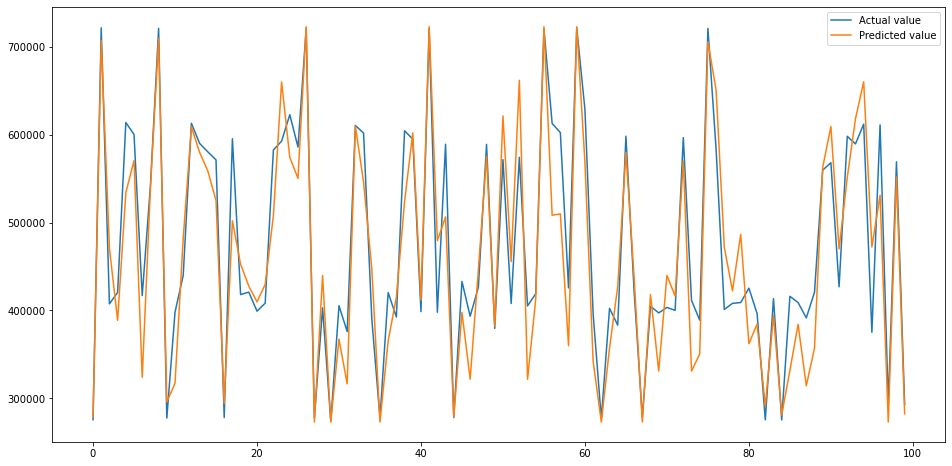

In [28]:
# Calculate the Feature Importance Score
feature_ranks = pd.DataFrame(best_model.feature_importances_ , columns = ['Feature Importance Score'], index = df.columns)
feature_ranks = feature_ranks.sort_values(['Feature Importance Score'], ascending = False)
print(round(feature_ranks, 3))

# Create a visual comparison of the winning model predicted prices VS actual prices
test = pd.DataFrame({'Predicted value': y_pred_rf, 'Actual value': y_test})
fig = plt.figure(figsize = (16,8))
test = test.reset_index()
test = test.drop(['index'], axis = 1)
plt.plot(test)
plt.legend(['Actual value', 'Predicted value'])

> The Feature Importance scores produced by the Random Forest Regressor are aligned with the correlation score generated by the heatmap. They both rank the 'bath' as the feature has the highest correlation with the target variable 'price'.

# Insights on the Features
This model was created using a Python Library Lime (Local Interpretable Model-agnostic Explanations). The model provides insights on how a selected model measures the contribution of each feature to the prediction of a data sample.

In [29]:
import lime
from lime import lime_tabular

# Prepare the data for modeling and create a Lime model for the dataset
X, Y = data.drop(['price'], axis = 1).values, data.price.values
model_lime = RandomForestRegressor()
model_lime.fit(X, Y)

# Extract the explainer from the modeling results
explainer = lime_tabular.LimeTabularExplainer(np.array(X), 
                                              feature_names = df.columns, 
                                              class_names = 'price',
                                              mode = 'regression')

In [30]:
# Apply the explainer to individual dataset instance
exp = explainer.explain_instance(x_train[50], 
     model_lime.predict, num_features = 10)

# Create a visual presentation of the instance explained by Lime
exp.show_in_notebook(show_table = True, show_all = False)

In [31]:
# Output a list of explanations from the modeling results
pd.DataFrame(exp.as_list(), columns = ['Feature Evaluation', 'Weight'])

,Feature Evaluation,Weight
0,bath <= 2.00,-240686.872481
1,parking_Covered <= 0.00,-7511.567616
2,dist_am2 <= 9229.25,5266.800442
3,precip <= 610.00,-3931.283276
4,dist_am3 <= 11215.75,-3765.704499
5,sqft <= 1588.50,-3683.711062
6,parking_Not Provided <= 0.00,2364.024903
7,0.00 < parking_Open <= 1.00,-2302.719442
8,elevation <= 27.00,-1868.147123
9,dist_am1 <= 6439.75,-523.905462


> The Feature Weight produced by the Lime model is aligned with the Feature Importance scores of the winning model (Random Forest Regressor).